In [1]:
from tools.utils import *
from tools.hom_networks import *

import torch

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# Random
seed = 42

# Model
hidden_channels = 128
num_classes = 6
num_layers = 2
aggr='mean'
dropout = 0.5 # Validated choice in experiment 2

# Training
batch_size = 32
epochs = 30
lr = 1e-4
maxlr = 3e-4

# Preprocess

In [3]:
# Load the ENZYMES dataset
hom_dataset = TUDataset(root='data', name='ENZYMES')                          # This has 3 one-hot encodings
hom_dataset_attr = TUDataset(root='data', name='ENZYMES', use_node_attr=True) # This has 3 one-hot encodings and 18 features

In [4]:
def normalize_enzymes_data(data):
    data = data.clone()
    if hasattr(data, 'x') and data.x is not None:
        x = data.x
        feats = x[:, :18]
        mean = feats.mean(dim=0)
        std = feats.std(dim=0, unbiased=False)
        std[std == 0] = 1.0
        normalized_feats = (feats - mean) / std
        x[:, :18] = normalized_feats
        data.x = x
    return data

# Normalize features
normalized_hom_dataset_attr = [normalize_enzymes_data(hom_data) for hom_data in hom_dataset_attr]

In [5]:
# Create splits
labels = [data.y.item() for data in normalized_hom_dataset_attr]

train_set, temp_set = train_test_split(
    normalized_hom_dataset_attr, 
    test_size=0.3, 
    stratify=labels,
    random_state=seed
    
)

temp_labels = [data.y.item() for data in temp_set]
valid_set, test_set = train_test_split(
    temp_set, 
    test_size=0.5, 
    stratify=temp_labels,
    random_state=seed
)

# train_loader is defined at each experiment for reproducibility
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Weight decay 1e-4 GraphConv

In [6]:
decay = 1e-4

In [7]:
experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model

HomoGNN_GraphConv(
  (node_emb_layers): ModuleList(
    (0): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
  )
  (conv_blocks): ModuleList(
    (0-1): 2 x ModuleDict(
      (conv): GraphConv((-1, -1), 128)
      (post_lin): MLP(
        (layers): ModuleList(
          (0): Linear(-1, 128, bias=True)
          (1): Dropout(p=0.5, inplace=False)
          (2): Linear(128, 128, bias=True)
        )
      )
    )
  )
  (classifier): Linear(128, 6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [8]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [9]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/30
Train Loss: 1.7934 | Validation Loss: 1.7934
Train Acc: 0.1690 | Validation Acc: 0.1667
Train F1: 0.0800 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.7935 | Validation Loss: 1.7933
Train Acc: 0.1619 | Validation Acc: 0.1667
Train F1: 0.0754 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.7932 | Validation Loss: 1.7932
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0774 | Validation F1: 0.0476

Epoch 4/30
Train Loss: 1.7933 | Validation Loss: 1.7931
Train Acc: 0.1619 | Validation Acc: 0.1667
Train F1: 0.0679 | Validation F1: 0.0476

Epoch 5/30
Train Loss: 1.7932 | Validation Loss: 1.7930
Train Acc: 0.1810 | Validation Acc: 0.1667
Train F1: 0.0821 | Validation F1: 0.0476

Epoch 6/30
Train Loss: 1.7929 | Validation Loss: 1.7928
Train Acc: 0.1571 | Validation Acc: 0.1667
Train F1: 0.0732 | Validation F1: 0.0476

Epoch 7/30
Train Loss: 1.7931 | Validation Loss: 1.7929
Train Acc: 0.1833 | Validation Acc: 0.1667
Train F1: 0.0917 | Validation F1: 0.0476

Epoch 8/30
Tr

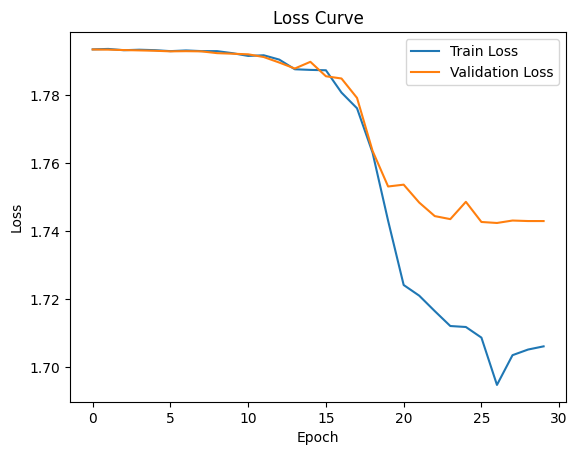

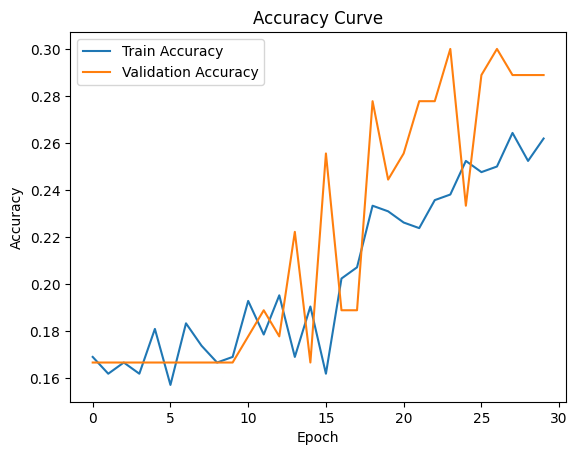

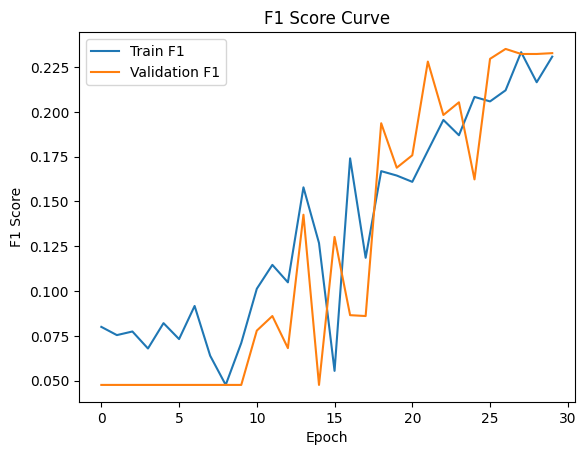

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7934,1.7934,0.1690,0.1667,0.0800,0.0476
1,2,1.7935,1.7933,0.1619,0.1667,0.0754,0.0476
2,3,1.7932,1.7932,0.1667,0.1667,0.0774,0.0476
3,4,1.7933,1.7931,0.1619,0.1667,0.0679,0.0476
4,5,1.7932,1.7930,0.1810,0.1667,0.0821,0.0476
5,6,1.7929,1.7928,0.1571,0.1667,0.0732,0.0476
6,7,1.7931,1.7929,0.1833,0.1667,0.0917,0.0476
7,8,1.7929,1.7928,0.1738,0.1667,0.0639,0.0476
8,9,1.7929,1.7923,0.1667,0.1667,0.0476,0.0476
9,10,1.7923,1.7921,0.1690,0.1667,0.0710,0.0476


In [10]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# Weight decay 5e-4 GraphConv

In [11]:
decay = 5e-4

In [12]:
experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model

HomoGNN_GraphConv(
  (node_emb_layers): ModuleList(
    (0): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
  )
  (conv_blocks): ModuleList(
    (0-1): 2 x ModuleDict(
      (conv): GraphConv((-1, -1), 128)
      (post_lin): MLP(
        (layers): ModuleList(
          (0): Linear(-1, 128, bias=True)
          (1): Dropout(p=0.5, inplace=False)
          (2): Linear(128, 128, bias=True)
        )
      )
    )
  )
  (classifier): Linear(128, 6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [13]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [14]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/30
Train Loss: 1.7934 | Validation Loss: 1.7934
Train Acc: 0.1690 | Validation Acc: 0.1667
Train F1: 0.0800 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.7935 | Validation Loss: 1.7933
Train Acc: 0.1643 | Validation Acc: 0.1667
Train F1: 0.0763 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.7932 | Validation Loss: 1.7932
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0778 | Validation F1: 0.0476

Epoch 4/30
Train Loss: 1.7933 | Validation Loss: 1.7931
Train Acc: 0.1619 | Validation Acc: 0.1667
Train F1: 0.0679 | Validation F1: 0.0476

Epoch 5/30
Train Loss: 1.7932 | Validation Loss: 1.7930
Train Acc: 0.1810 | Validation Acc: 0.1667
Train F1: 0.0828 | Validation F1: 0.0476

Epoch 6/30
Train Loss: 1.7929 | Validation Loss: 1.7929
Train Acc: 0.1595 | Validation Acc: 0.1667
Train F1: 0.0715 | Validation F1: 0.0476

Epoch 7/30
Train Loss: 1.7932 | Validation Loss: 1.7930
Train Acc: 0.1786 | Validation Acc: 0.1667
Train F1: 0.0871 | Validation F1: 0.0476

Epoch 8/30
Tr

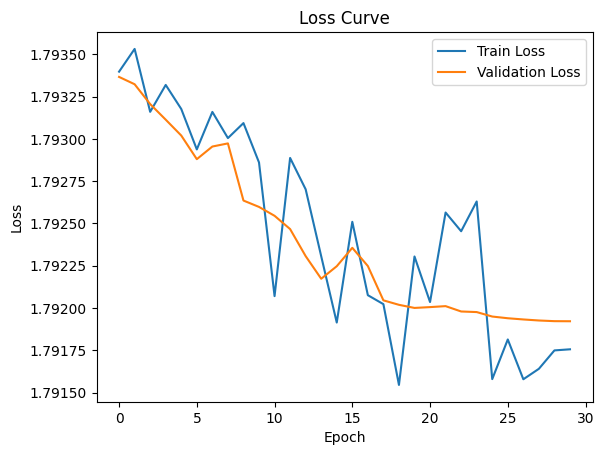

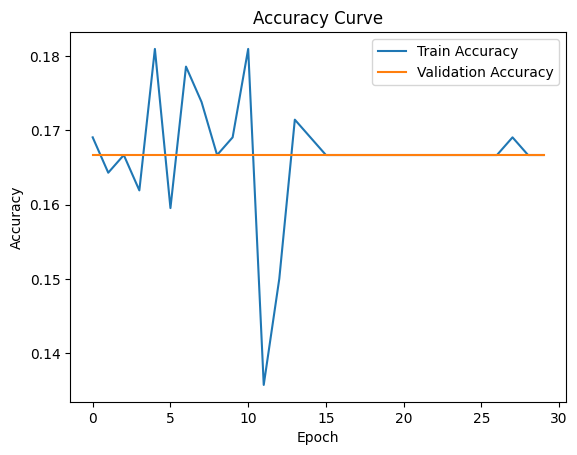

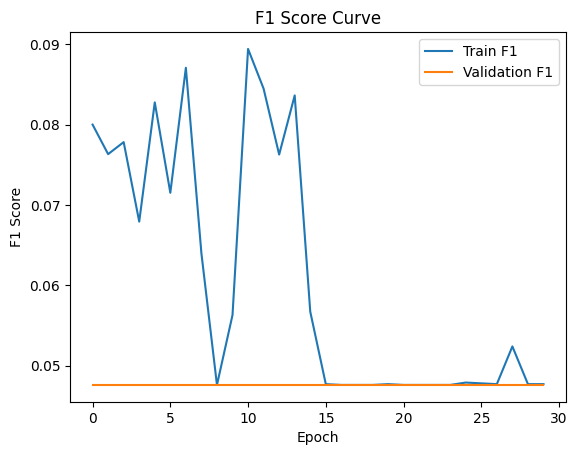

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7934,1.7934,0.1690,0.1667,0.0800,0.0476
1,2,1.7935,1.7933,0.1643,0.1667,0.0763,0.0476
2,3,1.7932,1.7932,0.1667,0.1667,0.0778,0.0476
3,4,1.7933,1.7931,0.1619,0.1667,0.0679,0.0476
4,5,1.7932,1.7930,0.1810,0.1667,0.0828,0.0476
5,6,1.7929,1.7929,0.1595,0.1667,0.0715,0.0476
6,7,1.7932,1.7930,0.1786,0.1667,0.0871,0.0476
7,8,1.7930,1.7930,0.1738,0.1667,0.0640,0.0476
8,9,1.7931,1.7926,0.1667,0.1667,0.0476,0.0476
9,10,1.7929,1.7926,0.1690,0.1667,0.0563,0.0476


In [15]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# Weight decay 1e-3 GraphConv

In [16]:
decay = 1e-3 

In [17]:
experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model

HomoGNN_GraphConv(
  (node_emb_layers): ModuleList(
    (0): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
  )
  (conv_blocks): ModuleList(
    (0-1): 2 x ModuleDict(
      (conv): GraphConv((-1, -1), 128)
      (post_lin): MLP(
        (layers): ModuleList(
          (0): Linear(-1, 128, bias=True)
          (1): Dropout(p=0.5, inplace=False)
          (2): Linear(128, 128, bias=True)
        )
      )
    )
  )
  (classifier): Linear(128, 6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [18]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [19]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/30
Train Loss: 1.7934 | Validation Loss: 1.7934
Train Acc: 0.1690 | Validation Acc: 0.1667
Train F1: 0.0800 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.7935 | Validation Loss: 1.7933
Train Acc: 0.1619 | Validation Acc: 0.1667
Train F1: 0.0744 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.7932 | Validation Loss: 1.7932
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0779 | Validation F1: 0.0476

Epoch 4/30
Train Loss: 1.7933 | Validation Loss: 1.7931
Train Acc: 0.1643 | Validation Acc: 0.1667
Train F1: 0.0689 | Validation F1: 0.0476

Epoch 5/30
Train Loss: 1.7932 | Validation Loss: 1.7930
Train Acc: 0.1810 | Validation Acc: 0.1667
Train F1: 0.0830 | Validation F1: 0.0476

Epoch 6/30
Train Loss: 1.7930 | Validation Loss: 1.7929
Train Acc: 0.1690 | Validation Acc: 0.1667
Train F1: 0.0755 | Validation F1: 0.0476

Epoch 7/30
Train Loss: 1.7932 | Validation Loss: 1.7930
Train Acc: 0.1786 | Validation Acc: 0.1667
Train F1: 0.0847 | Validation F1: 0.0476

Epoch 8/30
Tr

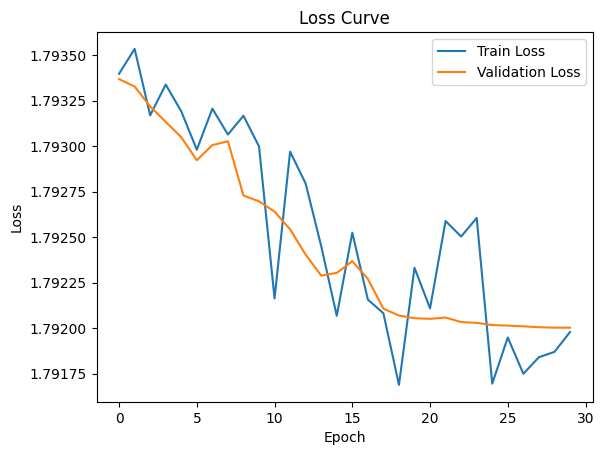

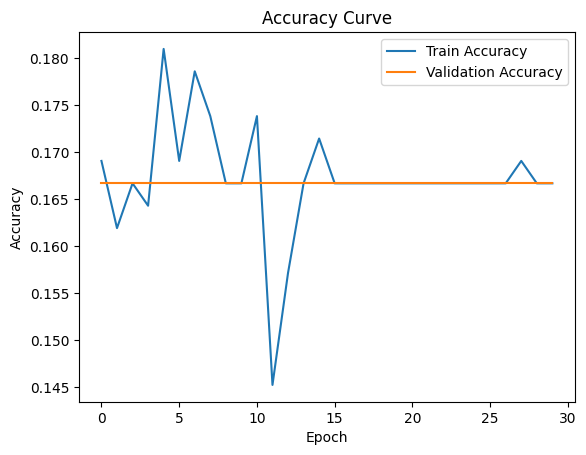

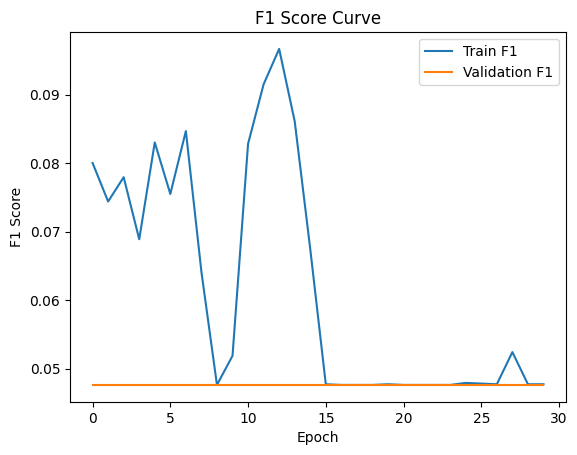

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7934,1.7934,0.1690,0.1667,0.0800,0.0476
1,2,1.7935,1.7933,0.1619,0.1667,0.0744,0.0476
2,3,1.7932,1.7932,0.1667,0.1667,0.0779,0.0476
3,4,1.7933,1.7931,0.1643,0.1667,0.0689,0.0476
4,5,1.7932,1.7930,0.1810,0.1667,0.0830,0.0476
5,6,1.7930,1.7929,0.1690,0.1667,0.0755,0.0476
6,7,1.7932,1.7930,0.1786,0.1667,0.0847,0.0476
7,8,1.7931,1.7930,0.1738,0.1667,0.0641,0.0476
8,9,1.7932,1.7927,0.1667,0.1667,0.0476,0.0476
9,10,1.7930,1.7927,0.1667,0.1667,0.0519,0.0476


In [20]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)